In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import gc
import psutil
import os

In [13]:
train_labels = pd.read_csv('train_annotations.csv')
train_labels.iloc[:,0][0]

numpy.int64

In [14]:
img_height = 720
img_width = 720


Found 3100 files belonging to 1 classes.
Using 2480 files for training.


In [21]:
ds_train = tf.keras.utils.image_dataset_from_directory("train",
                                                       labels='inferred',
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=111,
                                                       image_size=(img_height, img_width))

Found 3100 files belonging to 2 classes.
Using 2480 files for training.


In [22]:
ds_validation = tf.keras.utils.image_dataset_from_directory("train",
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    seed=111,
    image_size=(img_height, img_width))

Found 3100 files belonging to 2 classes.
Using 620 files for validation.


In [24]:
ds_train.class_names

['container', 'nocontainer']

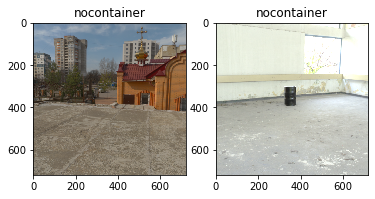

In [28]:
#plt.figure()
#for images, labels in ds_train.take(1):
#    for i in range(6):
#        ax=plt.subplot(2,3,i+1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(ds_train.class_names[labels[i]])

In [32]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [37]:
ds_train_n = ds_train.map(lambda x, y: (normalization_layer(x), y))
ds_validation_n = ds_validation.map(lambda x, y: (normalization_layer(x), y))

In [36]:
AUTOTUNE = tf.data.AUTOTUNE

In [38]:
ds_train_n = ds_train_n.cache().shuffle(2).prefetch(buffer_size=20)
ds_validation_n = ds_validation_n.cache().shuffle(2).prefetch(buffer_size=20)

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self,epoch,logs=None):
    print('**Epoch {}**'.format(epoch))
    print('Memory usage on epoch begin: {}'.format(psutil.Process(os.getpid()).memory_info().rss))
    
  def on_epoch_end(self, epoch, logs=None):
    print('Memory usage on epoch end:   {}'.format(psutil.Process(os.getpid()).memory_info().rss))
    tf.keras.backend.clear_session()
    gc.collect()

In [39]:
num_classes=2

model = tf.keras.Sequential([
  #tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Conv2D(32, 3, activation='relu'),
  #tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Conv2D(32, 3, activation='relu'),
  #tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(5, activation='relu'),
  tf.keras.layers.Dense(num_classes+1)
])


In [40]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [ ]:
model.fit(ds_train_n, validation_data=ds_validation_n, epochs=3,callbacks=[MyCustomCallback()])

Epoch 1/3
